In [86]:
import json
from pprint import pprint
from pathlib import Path

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uproot
from scipy.stats import bootstrap, norm

In [88]:
from gsfanalysis.pandas_import import uproot_to_pandas

In [89]:
input_dir = Path("../output/odd_g4_n10_05_20GeV_12cmps_smeared")

In [90]:
summary = uproot_to_pandas(uproot.open(str(input_dir / "root/tracksummary_gsf.root:tracksummary")))
summary.head(3)

,event_nr,multiTraj_nr,nStates,nMeasurements,nOutliers,nHoles,nSharedHits,chi2Sum,NDF,nMajorityHits,majorityParticleId,t_charge,t_time,t_vx,t_vy,t_vz,t_px,t_py,t_pz,t_theta,t_phi,t_eta,t_p,t_pT,t_d0,t_z0,hasFittedParams,eLOC0_fit,eLOC1_fit,ePHI_fit,eTHETA_fit,eQOP_fit,eT_fit,err_eLOC0_fit,err_eLOC1_fit,err_ePHI_fit,err_eTHETA_fit,err_eQOP_fit,err_eT_fit,res_eLOC0_fit,res_eLOC1_fit,res_ePHI_fit,res_eTHETA_fit,res_eQOP_fit,res_eT_fit,pull_eLOC0_fit,pull_eLOC1_fit,pull_ePHI_fit,pull_eTHETA_fit,pull_eQOP_fit,pull_eT_fit
0,0,0,26,2,10,1,0,11.642473,21,2,4503599644147712,-1,2051.255127,-0.006878,0.006443,26.299278,0.622633,0.928606,1.189748,0.754330,0.980142,0.926015,1.632630,1.118026,0.009424,26.299278,True,279.057220,113.663254,0.793448,0.753223,-0.221551,2294.090332,167.000244,121.296974,0.306730,0.017348,0.362057,3001.842773,279.047791,87.363976,-0.186695,-0.001106,0.390957,242.835205,1.670942,0.720249,-0.608662,-0.063776,1.079824,0.080895
1,0,1,28,13,0,2,0,158.130554,22,13,9007199271518208,-1,813.277100,0.019740,0.009593,-26.055830,12.212738,-0.598122,2.786611,1.346724,-0.048936,0.225971,12.540890,12.227376,0.021948,-26.055830,True,-0.009276,-26.038843,-0.048518,1.346999,-0.080204,930.938416,0.027749,0.023712,0.000415,0.000208,0.008356,2997.924561,-0.031223,0.016987,0.000418,0.000275,-0.000465,117.661316,-1.125191,0.716385,1.006986,1.319988,-0.055610,0.039248
2,0,2,27,13,0,1,0,29.876938,23,13,13510798898888704,-1,-245.630630,-0.030489,0.007543,-13.932940,3.217871,9.834952,1.936180,1.385828,1.254587,0.186032,10.527572,10.347994,0.031408,-13.932940,True,0.023518,-13.921064,1.254855,1.385932,-0.094330,-405.065002,0.016320,0.015429,0.000275,0.000193,0.007180,2997.924561,-0.007890,0.011876,0.000267,0.000104,0.000659,-159.434372,-0.483476,0.769747,0.973770,0.536725,0.091764,-0.053182


In [91]:
with open(input_dir / "config.json") as f:
    config = json.load(f)
    
pprint(config)

{'acts-commit-hash': '1b6362688',
 'components': 12,
 'cutoff': 0.0001,
 'debug': False,
 'detector': 'odd',
 'disable_fatras_interactions': False,
 'erroronly': False,
 'events': 10,
 'fatras': False,
 'gsf': {'abortOnError': False,
         'disableAllMaterialHandling': False,
         'finalReductionMethod': 'FinalReductionMethod.maxWeight',
         'high_bhapprox': '/home/benjamin/Documents/athena/Tracking/TrkFitter/TrkGaussianSumFilter/Data/GeantSim_GT01_cdf_nC6_O5.par',
         'low_bhapprox': '/home/benjamin/Documents/athena/Tracking/TrkFitter/TrkGaussianSumFilter/Data/GeantSim_LT01_cdf_nC6_O5.par',
         'maxComponents': 12,
         'weightCutoff': 0.0001},
 'jobs': 1,
 'output': 'output/odd_g4_n10_05_20GeV_12cmps',
 'particle_smearing': None,
 'particles': 1000,
 'pick': -1,
 'plt_show': False,
 'pmax': 20.0,
 'pmin': 0.5,
 'seeding': 'smeared',
 'skip': 0,
 'skip_analysis': False,
 'smearing': 0.01,
 'surfaces': 10,
 'verbose': False}


In [100]:
conv_level = 0.95
res = bootstrap((summary["res_eQOP_fit"].to_numpy(),), np.mean, confidence_level=conv_level)
res.standard_error, res.confidence_interval

(0.0032621727,
 ConfidenceInterval(low=-0.03718409348805675, high=-0.02413863090921037))

In [105]:
np.std(summary["res_eQOP_fit"])

0.32658931612968445

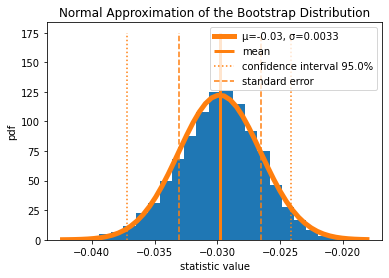

In [101]:
x = np.linspace(min(res.bootstrap_distribution), max(res.bootstrap_distribution))
sample_mean = np.mean(summary["res_eQOP_fit"])
pdf = norm.pdf(x, loc=sample_mean, scale=res.standard_error)

fig, ax = plt.subplots()
ax.hist(res.bootstrap_distribution, bins=25, density=True)
ax.plot(x, pdf, label="µ={:.2f}, σ={:.4f}".format(sample_mean, res.standard_error), lw=5)
ax.set_title('Normal Approximation of the Bootstrap Distribution')
ax.set_xlabel('statistic value')
ax.set_ylabel('pdf')

ax.vlines([sample_mean], ymin=0, ymax=175, color="tab:orange", lw=3, label="mean")
ax.vlines(res.confidence_interval, ymin=0, ymax=175, color="tab:orange", ls=":", label="confidence interval {:.1%}".format(conv_level))
ax.vlines([sample_mean + res.standard_error, sample_mean - res.standard_error], ymin=0, ymax=175, color="tab:orange", ls="--", label="standard error")

ax.legend()
plt.show()

In [103]:
num_samples = []
conv_low = []
conv_high = []
means = []
errors = []

for max_event_nr in range(max(summary["event_nr"])+1):
    df = summary[ summary["event_nr"] <= max_event_nr ]
    
    res = bootstrap((summary["res_eQOP_fit"].to_numpy(),), np.mean)
    
    conv_low.append(res.confidence_interval.low)
    conv_high.append(res.confidence_interval.high)
    num_samples.append(len(df))
    means.append(np.mean(summary["res_eQOP_fit"]))
    errors.append(res.standard_error)

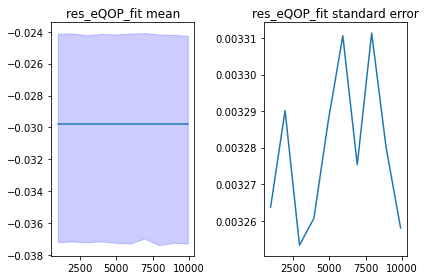

In [104]:
fig, ax = plt.subplots(1,2)
ax[0].plot(num_samples, means)
ax[0].set_title("res_eQOP_fit mean")
ax[0].fill_between(num_samples, conv_low, conv_high, color='b', alpha=.2)

ax[1].plot(num_samples, errors)
ax[1].set_title("res_eQOP_fit standard error")

fig.tight_layout()